In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, norm, zscore
import matplotlib.pyplot as plt 

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.decomposition import PCA
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

Explore the data: Begin by examining the data to understand the features (columns) and observations (rows) in the dataset. This may include looking at basic statistics like mean, median, and standard deviation, as well as visualizations like histograms and scatterplots.

Clean the data: Data cleaning is an important step in any machine learning project. This may involve removing or imputing missing values, addressing outliers, correcting errors, and transforming data that is in the wrong format or scale.

Feature engineering: This is the process of creating new features from the existing ones. This may involve creating interaction terms, scaling or normalizing data, or encoding categorical variables as dummy variables.

Check for correlations: Identify any correlations between the features, as this can help you understand the relationships between the different variables in the data.

Dimensionality reduction: Depending on the size and complexity of the dataset, you may need to reduce the number of features to avoid overfitting. This may involve techniques such as principal component analysis (PCA) or feature selection methods.

Split the data: Split the data into training and testing sets to evaluate the performance of your model on unseen data.

Import train and test data

In [2]:
path_to_data = r'C:\Users\User\Desktop\Main Folder\Job\Projects\House Prices - Advanced Regression Techniques\data\\'
train_data = pd.read_csv(path_to_data+'train.csv')
test_data = pd.read_csv(path_to_data+'test.csv')

## Data Exploration and Visualization

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have some integer variables that would be better to transform to object variables as they represent categorical values.
Also, we have some "nan" values that we should complete. Values "nan" that are in object variables we fill with "NA" values.
Values "nan" that are in continuous variables we fill with median values of similar data points.

<AxesSubplot: >

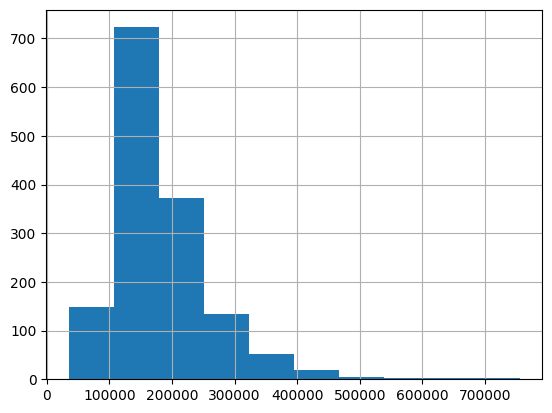

In [4]:
train_data['SalePrice'].hist()

According to the histogram we can see that target variable "SalePrice" is more or less normally distributed.

In [5]:
train_data.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

The correlation column of "SalePrice" relative to other variables is above.

Now let's convert some integer datatype variables into object datatype variables where it is reasonable.

In [6]:
def integer_to_object(columns ,dataframe):
    
    dataframe[columns] = dataframe[columns].astype('object')
    return dataframe

In [7]:
integer_to_object_columns = ['MSSubClass', 'MoSold']

train_data = integer_to_object(integer_to_object_columns, train_data)

The function below complete data cleaning proccess that was described previously. To complete "nan" values of integer and float datatype variables we should substitute them with median values of similar data points.
For example, if we have nan value in column "GrLivArea" in index 512, we do next steps:
- Find the most correlated variables to "GrLivArea", let call them "corr_variables";
- Find standard correlation of "corr_variables";
- Find similar data points (indicies) that are lying within 1 standard deviation of 512 index "corr_variables" values;
- When we found similar indicies (let's say [436, 687, 881]) we calculate the median of them and use it as a new value for index 512 

In [8]:
def cleaning_process(dataframe):
    
    object_columns = dataframe.select_dtypes(include = 'object').columns
    other_columns = dataframe.select_dtypes(exclude = 'object').columns
    
    
    #Clean object values
    dataframe[object_columns] = dataframe[object_columns].fillna('NA')
    
    #Clean other values
    for columns in other_columns:
        
        nan_index = dataframe.loc[dataframe[columns].isna(), columns].index
        correlated_variables = dataframe.corr()[columns].sort_values(ascending=False)[1:][:3].index
        
        std_correlated_variables = dataframe[correlated_variables].std()
        
        for nan_value in nan_index:
        
            values_correlated_variables = dataframe.iloc[nan_value][correlated_variables]

            range_correlated_values_min = values_correlated_variables - std_correlated_variables*0.5
            range_correlated_values_max = values_correlated_variables + std_correlated_variables*0.5

            similar_values = dataframe[(dataframe[correlated_variables] > range_correlated_values_min) &
                             (dataframe[correlated_variables] < range_correlated_values_max)][correlated_variables].dropna().index

            similar_values_mean = dataframe[other_columns].iloc[similar_values].median()
            dataframe[columns].iloc[nan_value] = similar_values_mean[columns]
            
    dataframe[other_columns] = dataframe[other_columns].fillna(dataframe[other_columns].median())
    
    return dataframe

In [9]:
train_data_sale_price = train_data[['SalePrice']]
train_data = cleaning_process(train_data.drop('SalePrice', 1))
train_data = pd.concat([train_data, train_data_sale_price], 1)

After we cleaned and completed nan values, let's check the statistical information about dataframe

In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1460.0,70.078510,22.491034,21.0,60.00,70.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.629110,180.679114,0.0,0.00,0.0,165.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


To properly analyze dataframe let's seperate object variables and other variables

In [11]:
numeric_columns = train_data.select_dtypes(exclude = 'object').columns
numeric_columns = numeric_columns.drop(['Id', 'SalePrice'], 1)
object_columns = train_data.select_dtypes(include = 'object').columns

Now let's check the skeweness of our data

In [12]:
skewness = train_data[numeric_columns].skew().sort_values(ascending=False)
skewness

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.672964
OpenPorchSF       2.364342
LotFrontage       2.224432
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
GarageYrBlt      -0.678333
dtype: float64

We can see that quite many of our data variables are skewed. Therefore, let's creat several transformation functions to transform our skewed variables and select best trnaformation function for every skewed variable

In [13]:
def square_root_transformation(dataframe, columns):
    
    dataframe[columns] = np.sqrt(dataframe[columns]+0.001)
    return dataframe

In [14]:
def cube_root_transformation(dataframe, columns):
    
    dataframe[columns] = (dataframe[columns]+0.001)**(1/3)
    return dataframe

In [15]:
def logarithm_transformation(dataframe, columns):
    
    dataframe[columns] = np.log(dataframe[columns]+0.001)
    return dataframe

In [16]:
def find_outliers(dataframe, threshold=4):
    
    zscores = pd.DataFrame(np.abs(zscore(dataframe)), columns=dataframe.columns, index=dataframe.index)

    outliers = zscores > threshold

    return outliers

In [17]:
best_transformation = pd.DataFrame()

variables = []
before_transform = []
best_transformer = []
logs = []
squares = []
cubes = []

for variable in skewness.index:
    

    variables.append(variable)
    check_column = train_data[[variable]]
    before_transform.append(np.abs(train_data[[variable]].skew()[variable]))
    square = np.abs(square_root_transformation(check_column, variable).skew()[variable])
    cube = np.abs(cube_root_transformation(check_column, variable).skew()[variable])
    log = np.abs(logarithm_transformation(check_column, variable).skew()[variable])

    best_dict = {'cube': cube, 'square': square, 'log': log}
    min_var = min(best_dict, key=lambda x: best_dict[x])
    best_transformer.append(min_var)
    logs.append(log)
    squares.append(square)
    cubes.append(cube)


    
    
best_transformation['variable'] = variables
best_transformation['best_transformer'] = best_transformer
best_transformation['square'] = squares
best_transformation['cube'] = cubes
best_transformation['logs'] = logs
best_transformation['before_transform'] = before_transform

After we applied transformation functions on variables, we can see the table with the most appropriate transformation functions for every variable. Also, in the table we can find the skew value after every transformation function, respectively

In [18]:
best_transformation

,variable,best_transformer,square,cube,logs,before_transform
0,MiscVal,log,9.567218,5.324114,5.052760,24.476794
1,PoolArea,log,14.465107,14.367743,14.355095,14.828374
2,LotArea,log,4.139714,0.867284,0.137786,12.207688
3,3SsnPorch,log,8.279801,7.728766,7.639077,10.304342
4,LowQualFinSF,log,8.067577,7.466764,7.334746,9.011341
5,KitchenAbvGr,square,3.206716,4.351700,16.415806,4.488397
6,BsmtFinSF2,log,3.038447,2.536971,2.447592,4.255261
7,ScreenPorch,log,3.355859,3.150153,3.120430,4.122214
8,BsmtHalfBath,log,3.896425,3.865249,3.861182,4.103403
9,EnclosedPorch,log,2.349140,2.104095,2.060234,3.089872


Now let's create a function that would take every varible in our dataframe and transform it with appropriate transformation function. The skew value treshold that we accept is 2

In [19]:
def feature_engineering(dataframe, columns, best_transformation):
    
    outliers_before_update = find_outliers(dataframe[columns])
    outliers_before_update = outliers_before_update[outliers_before_update == True].dropna(how = 'all').shape[0]
    print('Amount of outliers begore transformation is: {}'.format(outliers_before_update))
    
    skewness = dataframe[columns].skew().sort_values(ascending=False)

    
    for variable in skewness.index:
        
        if skewness[variable] > 2:
            best_transformer = best_transformation[best_transformation['variable'] == variable]['best_transformer'].iloc[-1]

            if best_transformer == 'log':
                dataframe[variable] = logarithm_transformation(dataframe, variable)[[variable]]

            elif best_transformer == 'square':
                dataframe[variable] = square_root_transformation(dataframe, variable)[[variable]]

            else:
                dataframe[variable] = cube_root_transformation(dataframe, variable)[[variable]]
        
    outliers_after_update = find_outliers(dataframe[columns])
    outliers_after_update = outliers_after_update[outliers_after_update == True].dropna(how = 'all').shape[0]
    print('Amount of outliers after transformation is: {}'.format(outliers_after_update))
    
    return dataframe

In [20]:
train_data = feature_engineering(train_data, numeric_columns, best_transformation)

Amount of outliers begore transformation is: 217
Amount of outliers after transformation is: 253


Let's check the skewness of data after transformation

In [21]:
train_data[numeric_columns].skew().sort_values(ascending=False)

PoolArea         14.355068
3SsnPorch         7.638787
LowQualFinSF      7.334348
MiscVal           5.052355
BsmtHalfBath      3.861150
KitchenAbvGr      3.206716
ScreenPorch       3.120345
BsmtFinSF2        2.447346
EnclosedPorch     2.060089
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
MasVnrArea        0.393471
LotFrontage       0.329911
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
OpenPorchSF       0.194088
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
LotArea          -0.137993
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
GarageYrBlt      -0.678333
dtype: float64

We saw that after transformation we have 253 outliers. Let's check them closer

In [22]:
outliers = find_outliers(train_data[numeric_columns])
print('The total amount of oultiers is {}'.format(outliers[outliers == True].dropna(how = 'all').shape[0]))
print('='*60)
print("The biggest amount of outliers have next variables:")
print("{}\n".format(outliers.sum().sort_values(ascending=False)[:5]))

The total amount of oultiers is 253
The biggest amount of outliers have next variables:
BsmtHalfBath    82
KitchenAbvGr    68
MiscVal         52
LowQualFinSF    26
3SsnPorch       24
dtype: int64



In [23]:
outlier_variables = outliers.sum().sort_values(ascending=False)[:5].index
print('Variables with biggest amount of outliers have such correlation to \'SalePrice\'')
train_data.corr()['SalePrice'][outlier_variables].sort_values(ascending = False)

Variables with biggest amount of outliers have such correlation to 'SalePrice'


3SsnPorch       0.046655
BsmtHalfBath   -0.016067
LowQualFinSF   -0.046407
MiscVal        -0.066126
KitchenAbvGr   -0.129196
Name: SalePrice, dtype: float64

In [24]:
train_data[outlier_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
BsmtHalfBath,1460.0,-6.518780,1.595301,-6.907755,-6.907755,-6.907755,-6.907755,0.693647
KitchenAbvGr,1460.0,1.019273,0.093077,0.031623,1.000500,1.000500,1.000500,1.732339
MiscVal,1460.0,-6.428340,2.500818,-6.907755,-6.907755,-6.907755,-6.907755,9.648595
LowQualFinSF,1460.0,-6.685014,1.657420,-6.907755,-6.907755,-6.907755,-6.907755,6.349141
3SsnPorch,1460.0,-6.708638,1.542468,-6.907755,-6.907755,-6.907755,-6.907755,6.230483


As "BsmtHalfBath" and "KitchenAbvGr" have very high sparsity,and their correlation to "SalePrice" are -0.01 and -0.12, respectively, then it would be reasonable to remove those variables from dataset to reduce the amount of outliers by 150. 

In [25]:
train_data = train_data.drop(['BsmtHalfBath', 'KitchenAbvGr'], 1)
numeric_columns = numeric_columns.drop(['BsmtHalfBath', 'KitchenAbvGr'], 1)

Next, we have to check the multi-collinearity between variables to decide whether to apply PCA (Principal Component Analysis)

<AxesSubplot: >

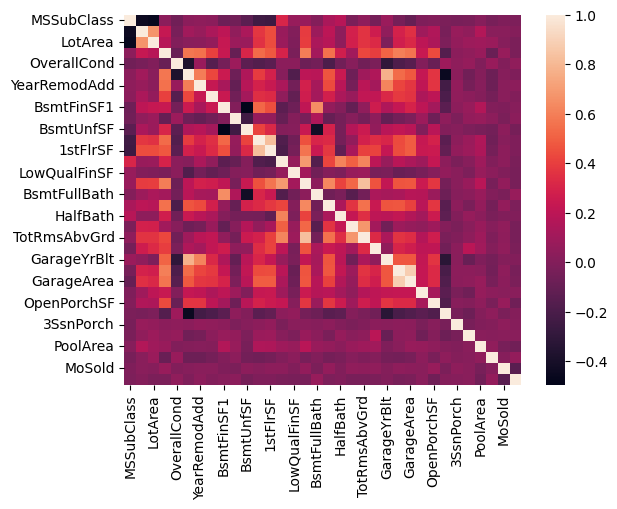

In [26]:
sns.heatmap(train_data[numeric_columns].corr(), )

In [31]:
def PCA_application(dataframe, columns, type_data, pca = None, n_components = None):
    
    if n_components == None:
        n_components = len(dataframe.columns)
    
    if type_data == 'train':
        pca = PCA(n_components=n_components)
        pca.fit(dataframe[columns])
        
    if type_data == 'test':
        pca.fit_transform(dataframe[columns])
        
    
    df_transformed = pd.DataFrame(pca.transform(dataframe[columns]))
    df_transformed.columns = columns
    
    dataframe[columns] = df_transformed[columns]
    
    return dataframe, pca, n_components

In [32]:
def PCA_application(dataframe, columns, type_data, pca=None, n_components=None):

    if n_components is None:
        n_components = len(columns)

    if pca is None:
        pca = PCA(n_components=n_components)
        pca.fit(dataframe[columns])

    if type_data == 'test':
        pca.transform(dataframe[columns])

    df_transformed = pd.DataFrame(pca.transform(dataframe[columns]), columns=[f"{col}_pca" for col in columns[:n_components]])
    dataframe = pd.concat([dataframe.drop(columns, axis=1), df_transformed], axis=1)

    return dataframe, pca, n_components

Now, let's encode categorical variables into numerical values

In [33]:
def label_encode(dataframe):
    for col in dataframe.select_dtypes(include='object'):
        if len(dataframe[col].unique()) > 2:
            le = LabelEncoder()
            dataframe[col] = le.fit_transform(dataframe[col])
        else:
            ohe = OneHotEncoder(drop='if_binary', sparse=False)
            dataframe[col] = ohe.fit_transform(dataframe[col].values.reshape(-1, 1))
    return dataframe

In [34]:
train_data = label_encode(train_data)

Now, we divide data into X input variables and y output 'SalePrice'

In [35]:
X_train_data = train_data.drop(['Id', 'SalePrice'], 1)
y_train_data = train_data[['SalePrice']]

As our data has quite amount of outliers, it would be better to use RobustScaler which is less sesitive to outliers

In [36]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(X_train_data)
X_train_data = pd.DataFrame(scaled_data, columns=X_train_data.columns)

Now let's divide our data for train and validation

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=111)

We will try 4 models:
- Linear Regression
- Random Forest
- Gradient Boosting Regressor
- Neural Network

and decide the best model based on RMSE (Root Mean Square Error) metric

In [38]:
#Linear Regression model

In [39]:
def regression_model(X_train, y_train, X_val, y_val):
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return y_pred, rmse, model

For Random Forest model and Gradient Boosting model I will apply GridSearchCV to find the best number of estimators

In [40]:
#Random Forest model

In [41]:
def random_forest_model(X_train, y_train, X_val, y_val):
    
    model = RandomForestRegressor()
    param_grid = {'n_estimators': [50, 100, 200, 350, 500, 750, 1000]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_n_estimators = grid_search.best_params_['n_estimators']
    
    model = RandomForestRegressor(n_estimators=best_n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return y_pred, rmse, model

In [42]:
#GradientBoostingRegressor

In [43]:
def gradient_boosting_model(X_train, y_train, X_val, y_val):
    
    model = model = GradientBoostingRegressor()
    param_grid = {'n_estimators': [50, 100, 200, 350, 500, 750, 1000]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_n_estimators = grid_search.best_params_['n_estimators']
    
    model = GradientBoostingRegressor(n_estimators=best_n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return y_pred, rmse, model

For Neural Network I will apply GridSearchCV to find the best values of hyperparameters:
   - number of layers;
   - number of neurons;
   - regularizer;
   - batch size;

In [44]:
#Neural Netork model

In [45]:
def neural_network_model(X_train, y_train, X_val, y_val):
    
    def create_model(n_layers, layer_size, regularizer):
        model = Sequential()
        
        div = 1
        
        for i in range(n_layers):
            model.add(Dense(int(layer_size/div), input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizer))
            div = 2
        model.add(Dense(1, activation='linear', kernel_regularizer=regularizer))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

    model = KerasRegressor(build_fn=create_model, verbose=0)

    param_grid = {
        'n_layers': [2, 3, 4, 5],
        'layer_size': [128, 256, 512, 1024],
        'regularizer': [regularizers.l2(0.001), regularizers.l2(0.01),
                       regularizers.l1(0.001), regularizers.l1(0.01)],
        'batch_size': [8, 16, 32]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    
    best_layer_size = best_params['layer_size']
    best_n_layers = best_params['n_layers']
    best_regularizer = best_params['regularizer']
    best_batch_size = best_params['batch_size']
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    model = Sequential()

    div = 1
    
    for i in range(best_n_layers):
        model.add(Dense(int(best_layer_size/div), input_dim=X_train.shape[1], activation='relu', kernel_regularizer=best_regularizer))
        div = 2
    model.add(Dense(1, activation='linear', kernel_regularizer=best_regularizer))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=best_batch_size, callbacks=[early_stopping])

    # Evaluate the model on the training data
    y_pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Evaluate the model on the test data
    y_pred_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    return y_pred_val, rmse_val, model


Now let's all model in a single function, train every model and decide the best one with the lowest RMSE

In [46]:
def find_best_model(X_train, y_train, X_val, y_val, numeric_columns):
    
    y_pred_rm, rmse_rm, model_rm = regression_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Regression model was successfuly completed')
    y_pred_rf, rmse_rf, model_rf = random_forest_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Random forest model was successfuly completed')
    y_pred_gb, rmse_gb, model_gb = gradient_boosting_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Gradient boosting model was successfuly completed')
    y_pred_nn, rmse_nn, model_nn = neural_network_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Neural network model was successfuly completed')
    
    models = [model_rm, model_rf, model_gb, model_nn]
    
    final_results = pd.DataFrame(y_val.copy())
    model_names = ['regression_model', 'random_forest_model', 'gradient_boosting_model', 'neural_network_model']

    final_results['regression_model_pred'] = y_pred_rm
    final_results['random_forest_pred'] = y_pred_rf
    final_results['gradient_boosting_pred'] = y_pred_gb
    final_results['neural_network_pred'] = y_pred_nn

    rmse = [rmse_rm, rmse_rf, rmse_gb, rmse_nn]
    all_rmse = {model_name: score for model_name, score in zip(model_names, rmse)}
    
    rmse_dict = {}

    for i in range(len(model_names)):
        rmse_dict[model_names[i]] = rmse[i]
        
    best_model_name = min(rmse_dict, key=rmse_dict.get)
    print('The best model is {} with rmse value of {}'.format(best_model_name, rmse_dict[best_model_name]))
    
    index = model_names.index(best_model_name)
    best_model = models[index]
        
    return final_results, rmse_dict, best_model_name, best_model

In [47]:
final_results, rmse_dict, best_model_name, best_model = find_best_model(X_train, y_train, X_val, y_val, numeric_columns)

Regression model was successfuly completed
Random forest model was successfuly completed
Gradient boosting model was successfuly completed
Epoch 1/100
128/128 [==============================] - 5s 35ms/step - loss: 9737791488.0000 - val_loss: 4518950912.0000
Epoch 2/100
128/128 [==============================] - 4s 33ms/step - loss: 2422571520.0000 - val_loss: 1668450048.0000
Epoch 3/100
128/128 [==============================] - 4s 33ms/step - loss: 2080890112.0000 - val_loss: 2764927232.0000
Epoch 4/100
128/128 [==============================] - 4s 33ms/step - loss: 1595827200.0000 - val_loss: 1391095808.0000
Epoch 5/100
128/128 [==============================] - 4s 34ms/step - loss: 1458159104.0000 - val_loss: 1403849216.0000
Epoch 6/100
128/128 [==============================] - 4s 34ms/step - loss: 1060522688.0000 - val_loss: 2898562304.0000
Epoch 7/100
128/128 [==============================] - 4s 34ms/step - loss: 1203293824.0000 - val_loss: 2339369728.0000
Epoch 8/100
128/128 [

Below I repeat the same process but with updated data by PCA function

In [48]:
train_data_pca, pca, n_components_pca = PCA_application(train_data.copy(), numeric_columns, 'train', pca=None, n_components=25)

X_train_data_pca = train_data_pca.drop(['Id', 'SalePrice'], 1)
y_train_data_pca = train_data_pca[['SalePrice']]

scaler_pca = RobustScaler()
scaled_data_pca = scaler_pca.fit_transform(X_train_data_pca)
X_train_data_pca = pd.DataFrame(scaled_data_pca, columns=X_train_data_pca.columns)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_data_pca, y_train_data_pca, test_size=0.3, random_state=111)

In [49]:
final_results_pca, rmse_dict_pca, best_model_name_pca, best_model_pca = find_best_model(X_train_pca, y_train_pca, X_val_pca, y_val_pca, numeric_columns)

Regression model was successfuly completed
Random forest model was successfuly completed
Gradient boosting model was successfuly completed
Epoch 1/100
128/128 [==============================] - 6s 41ms/step - loss: 11451419648.0000 - val_loss: 2228113408.0000
Epoch 2/100
128/128 [==============================] - 5s 39ms/step - loss: 2241059840.0000 - val_loss: 1679439616.0000
Epoch 3/100
128/128 [==============================] - 5s 39ms/step - loss: 1813181952.0000 - val_loss: 2009380736.0000
Epoch 4/100
128/128 [==============================] - 5s 39ms/step - loss: 1354476800.0000 - val_loss: 1758158336.0000
Epoch 5/100
128/128 [==============================] - 5s 39ms/step - loss: 1163958912.0000 - val_loss: 1648547456.0000
Epoch 6/100
128/128 [==============================] - 5s 40ms/step - loss: 864659136.0000 - val_loss: 1456489984.0000
Epoch 7/100
128/128 [==============================] - 5s 39ms/step - loss: 777553088.0000 - val_loss: 2731625984.0000
Epoch 8/100
128/128 [=

Now let's combine all models and their RMSEs into single dictionary to find the best model

In [50]:
for key in rmse_dict_pca:
    new_key = key + '_pca'
    rmse_dict[new_key] = rmse_dict_pca[key]

for key, value in rmse_dict.items():
    if value == sorted(rmse_dict.values())[0]:
        print('The best model is {} with root square mean error of {}'.format(key, value))

The best model is gradient_boosting_model with root square mean error of 27219.156210678262


Now, whe we have our best model, let's apply all transformation processes on test data and predict SalePrice on it

In [51]:
test_data = integer_to_object(integer_to_object_columns, test_data)
test_data = cleaning_process(test_data)
test_data = feature_engineering(test_data, numeric_columns, best_transformation)
test_data = test_data.drop(['BsmtHalfBath', 'KitchenAbvGr'], 1)
test_data = label_encode(test_data)

test_data_id = test_data['Id']
test_data = test_data.drop('Id', 1)

scaled_data_test = scaler.transform(test_data)
test_data = pd.DataFrame(scaled_data_test, columns=test_data.columns)

Amount of outliers begore transformation is: 138
Amount of outliers after transformation is: 105


In [52]:
y_test_pred = best_model.predict(test_data)

In [53]:
predictions = pd.DataFrame(y_test_pred, index=test_data_id, columns=['Predicted Sale Price'])
predictions['Predicted Sale Price'] = predictions['Predicted Sale Price'].astype(int)
predictions

,Predicted Sale Price
Id,
1461,122997
1462,162980
1463,176372
1464,179949
1465,191867
...,...
2915,77186
2916,72164
2917,150985


In [54]:
predictions.to_csv(path_to_data+str('predictions.csv'))